In [15]:
import numpy as np
from qutip import qeye, destroy, tensor, Qobj, basis
from qutip.core.gates import *
from qutip import *
import json
import numpy as np
from numpy import real
from matplotlib import pyplot as plt
from numpy import array
from numpy import real


pi = np.pi

# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------
# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------

def read_json_to_dict(filename: str) -> dict:
    """ Read a JSON file into a Python dictionary. """
    with open(filename, "r") as f:
        return json.load(f)

def ladder_operators(dim):
    """ Create ladder operators for a given dimension, return them as numpy arrays. """
    a = destroy(dim)
    adag = a.dag()
    return a.full(), adag.full()

def _tensor(*ops):
    """Kronecker product of multiple operators (NumPy arrays)."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

def build_projector(vectors, i, j):
    """Build projector |i><j| from the i-th and j-th eigenvectors from the supplied set of vectors."""
    ket = vectors[:, i][:, np.newaxis]
    bra = vectors[:, j][:, np.newaxis].conj().T

    projector = ket @ bra
    return projector

def build_qubit_cavity_vibronic_coupling(H_qubit_cavity_coupling, omega_list, gv_list, boson_dim, qubit_number=1):
    
    ### The problem is H_qubit_cavity_coupling is in the full Hilbert space
    ### but we want it in the qubit-cavity subspace only

    # try tracing out extra degree of freedom
    if qubit_number == 1:
        H_qubit_cavity_coupling = H_qubit_cavity_coupling.ptrace([0,1])
    elif qubit_number == 2:
        H_qubit_cavity_coupling = H_qubit_cavity_coupling.ptrace([1,2])

    # this has polariton dim bc we traced out other degrees of freedom
    H_coup_np = H_qubit_cavity_coupling.full()
    polariton_dim = H_coup_np.shape[0]
    vals, vecs = np.linalg.eigh(H_coup_np)

    # operators on the local bosonic space
    a_np, adag_np = ladder_operators(boson_dim)
    n_np = adag_np @ a_np
    Iq_np = np.eye(2, dtype=complex)
    Iv_np = np.eye(boson_dim, dtype=complex)

    # total Hilbert space if qubit_number == 1: polariton ⊗ qubit2 ⊗ vib1 ⊗ vib2
    # and if                 qubit_number == 2: qubit1 ⊗ polariton ⊗ vib1 ⊗ vib2
    total_dim = polariton_dim * 2 * boson_dim * boson_dim
    H_vib = np.zeros((total_dim, total_dim), dtype=complex)
    H_vib_coup = np.zeros_like(H_vib)

    for i in range(polariton_dim):
        Proj_ii = build_projector(vecs, i, i)
        if qubit_number==1:
            op_n = _tensor(Proj_ii, Iq_np, n_np, Iv_np)
        elif qubit_number==2:
            op_n = _tensor(Iq_np, Proj_ii, Iv_np, n_np)

        H_vib += omega_list[i] * op_n

        if i > 0:
            Proj_0i = build_projector(vecs, 0, i) + build_projector(vecs, i, 0)

            if qubit_number==1:
                op_c = _tensor(Proj_0i, Iq_np, (a_np + adag_np), Iv_np)
            elif qubit_number==2:
                op_c = _tensor(Iq_np, Proj_0i, Iv_np, (a_np + adag_np))

            H_vib_coup = gv_list[i] * op_c

    qubit_dims = [2, boson_dim, 2, boson_dim, boson_dim]
    return Qobj(H_vib + H_vib_coup, dims=[qubit_dims, qubit_dims])
    
        
# -----------------------------------------------------------
# runner function
# -----------------------------------------------------------
def runner(params, LiH_params, psi0, rho_qubits_ideal, tlist, Nf, omega_vib_list):
    """
    Objective: minimize 1 - fidelity with ideal Bell state.
    params = [gv_1, gv_2, gv_5, T_gate_1, T_gate_2]
    """
    gv_list = np.zeros_like(omega_vib_list)
    gv_list[0] = 0.0
    gv_list[1] = params[0] # gs to LP
    gv_list[2] = params[1] # gs to UP
    gv_list[3] = 0.0       # gs to S0
    gv_list[4] = params[2] # gs to S1
    gv_list[5] = params[2] # gs to S1 
    
    T_gate_1, T_gate_2 = params[3], params[4]

    global T0_1, T0_2
    T0_1 = 20
    T0_2 = T0_1 + T_gate_1

    # System constants
    omega_q = LiH_params["w_q1"]
    omega_c = omega_q
    omega_v = LiH_params["w_vib1"]
    mu_eg = LiH_params["qubit_1_dipole_moments"]["mu_eg"]
    mu_ee = LiH_params["qubit_1_dipole_moments"]["mu_e"]
    mu_gg = LiH_params["qubit_1_dipole_moments"]["mu_g"]
    lv = 0.01

    gc_fixed = np.sqrt(omega_c / 2) * lv * np.abs(mu_eg)
    d_matrix_fixed = lv * np.array([[mu_gg, mu_eg], [mu_eg, mu_ee]])
    d_qobj = Qobj(d_matrix_fixed)

    # Local operators
    sz, sm, sp = sigmaz(), destroy(2), destroy(2).dag()
    nq = sp * sm
    am, ap = destroy(Nf), destroy(Nf).dag()
    nc = ap * am
    Iq, Ic, Iv = qeye(2), qeye(Nf), qeye(Nf)

    # operators in the full Hilbert space for expectation values
    ncav = tensor(Iq, nc, Iq, Iv, Iv)
    nq1 = tensor(nq, Ic, Iq, Iv, Iv)
    nq2 = tensor(Iq, Ic, nq, Iv, Iv)

    # Build Hamiltonians
    H_q1 = tensor(-omega_q / 2 * sz, Ic, Iq, Iv, Iv)
    H_cav = tensor(Iq, omega_c * nc, Iq, Iv, Iv)
    H_q2 = tensor(Iq, Ic, -omega_q / 2 * sz, Iv, Iv)
    H_v1 = tensor(Iq, Ic, Iq, omega_v * nc, Iv)
    H_v2 = tensor(Iq, Ic, Iq, Iv, omega_v * nc)

    H_q1_cav_JC = gc_fixed * (tensor(sp, am, Iq, Iv, Iv) + tensor(sm, ap, Iq, Iv, Iv))
    H_q2_cav_JC = gc_fixed * (tensor(Iq, am, sp, Iv, Iv) + tensor(Iq, ap, sm, Iv, Iv))

    H_q1_v1 = gv_list[4] * tensor(sp * sm, Ic, Iq, (am + ap), Iv)
    H_q2_v2 = gv_list[4] * tensor(Iq, Ic, sp * sm, Iv, (am + ap))

    # Vibronic coupling Hamiltonians
    H_q1_vib1_coupled = build_qubit_cavity_vibronic_coupling(
        H_q1 + H_cav + H_q1_cav_JC, omega_vib_list, gv_list, Nf, qubit_number=1
    )
    H_q2_vib2_coupled = build_qubit_cavity_vibronic_coupling(
        H_q2 + H_cav + H_q2_cav_JC, omega_vib_list, gv_list, Nf, qubit_number=2
    )

    # Time-dependent Hamiltonian parts
    def wc_t(t, args=None): return 1 if t <= T0_1 else 0
    def w1_t(t, args=None): return 1 if T0_1 < t <= T0_1 + T_gate_1 else 0
    def w2_t(t, args=None): return 1 if T0_2 < t <= T0_2 + T_gate_2 else 0

    H_uncoupled = H_q1 + H_cav + H_q2 + H_v1 + H_v2 + H_q1_v1 + H_q2_v2
    H_q1_cav_coupled = H_q1 + H_cav + H_q1_cav_JC + H_q2 + H_v1 + H_v2 + H_q1_vib1_coupled + H_q2_v2
    H_q2_cav_coupled = H_q1 + H_cav + H_q2_cav_JC + H_q2 + H_v1 + H_v2 + H_q1_v1 + H_q2_vib2_coupled

    H_t_PF = [[H_uncoupled, wc_t], [H_q1_cav_coupled, w1_t], [H_q2_cav_coupled, w2_t]]

    res = mesolve(H_t_PF, psi0, tlist, [], e_ops=[])


    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

    axes[0].plot(tlist, array(list(map(wc_t, tlist))), 'r', linewidth=2, label="cavity")
    axes[0].plot(tlist, array(list(map(w1_t, tlist))), 'b', linewidth=2, label="qubit 1")
    axes[0].plot(tlist, array(list(map(w2_t, tlist))), 'g', linewidth=2, label="qubit 2")
    #axes[0].set_ylim(1, 6)
    axes[0].set_ylabel("Energy (a.u.)", fontsize=16)
    axes[0].legend()

    axes[1].plot(tlist, real(expect(ncav, res.states)), 'r', linewidth=2, label="cavity")
    axes[1].plot(tlist, real(expect(nq1, res.states)), 'b', linewidth=2, label="qubit 1")
    axes[1].plot(tlist, real(expect(nq2, res.states)), 'g', linewidth=2, label="qubit 2")
    axes[1].set_xlabel("Time (a.u.)", fontsize=16)
    axes[1].set_ylabel("Occupation probability", fontsize=16)
    axes[1].legend()

    fig.tight_layout()


    rho_final = res.states[-1]

    rho_qubits = ptrace(rho_final, [0,2])
    print(rho_qubits)
    fide = fidelity(rho_qubits, rho_qubits_ideal)
    conc = concurrence(rho_qubits)

    # store for inspection
    objective.last_fid = fide
    objective.last_conc = conc
    print(F"fidelity is {fide}")
    print(F"concurrence is {conc}")
    print(F"Final rho is \n {rho_qubits}")

    return rho_qubits, fide, conc

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.38764902e-05+0.00000000e+00j -2.96136210e-22-7.48638402e-23j
   3.93884242e-24-4.46151455e-23j  0.00000000e+00+0.00000000e+00j]
 [-2.96136210e-22+7.48638402e-23j  4.97339322e-01+0.00000000e+00j
  -4.90235380e-01+2.22881169e-02j  1.40438679e-19-1.60022835e-18j]
 [ 3.93884242e-24+4.46151455e-23j -4.90235380e-01-2.22881169e-02j
   5.02643793e-01+0.00000000e+00j  1.22898684e-19-6.21910962e-20j]
 [ 0.00000000e+00+0.00000000e+00j  1.40438679e-19+1.60022835e-18j
   1.22898684e-19+6.21910962e-20j  3.00910851e-06+0.00000000e+00j]]
fidelity is 0.99510147094827
concurrence is 0.9814706231991973
Final rho is 
 Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.38764902e-05+0.00000000e+00j -2.96136210e-22-7.48638402e-23j
   3.93884242e-24-4.46151455e-23j  0.00000000e+00+0.00000000e+00j]
 [-2.96136210e-22+7.48638402e-23j  4.97339322e-01+

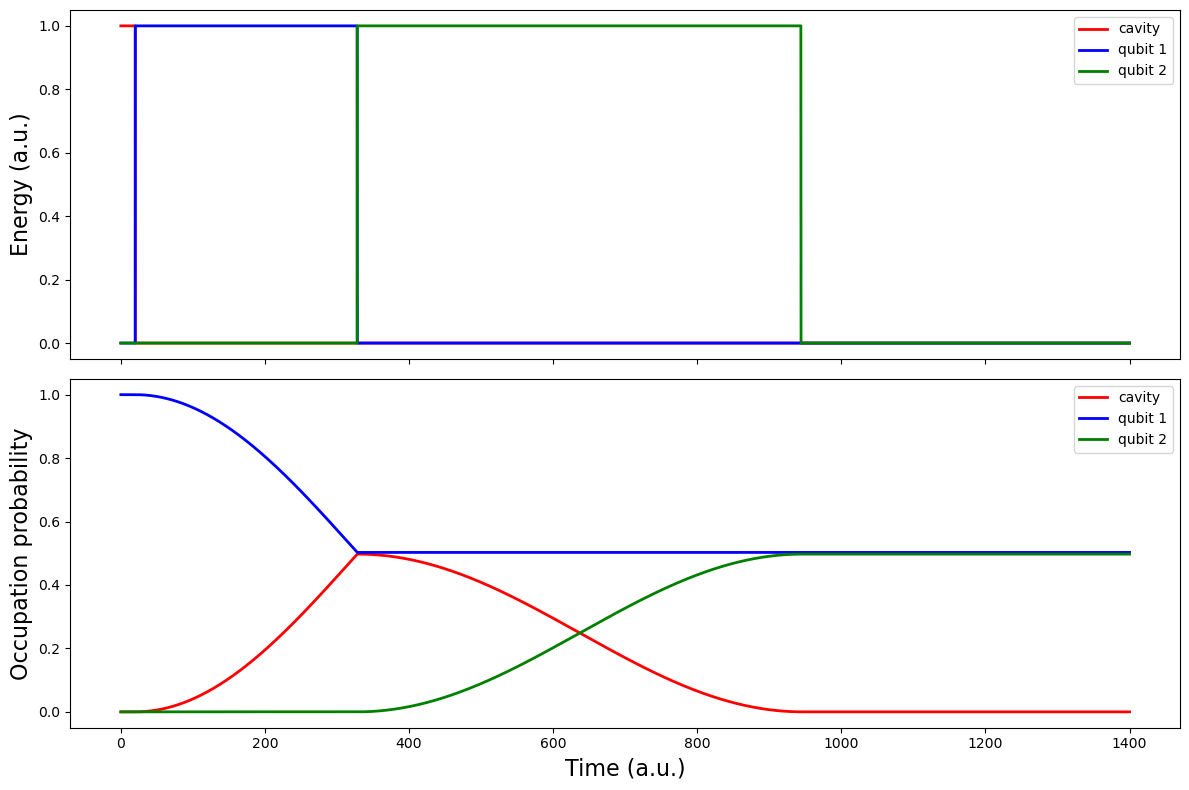

In [35]:
# -----------------------------------------------------------
# Load system parameters (LiH example)
# -----------------------------------------------------------
LiH_params = read_json_to_dict("LiH_params.json")

# vibrational frequencies for polariton states - to be fixed
omega_vib_list = [0.006, # omega on gs
                  0.006, # omega on LP
                  0.006, # omega on UP
                  0.006, # omega on S0
                  0.006, # omega on S1
                  0.006] # omega on S1 

Nf = 3  # bosonic cutoff

#good_params = [7.74557860e-01, 6.55479084e-01, 6.40516069e-04, 2.85479981e+02, 5.58060919e+02]
good_params = [7.74e-1, 6.55e-1, 6.4e-4, 308, 616]

# initial psi
psi_init = tensor(basis(2,1), basis(Nf,0),
              basis(2,0), basis(Nf,0), basis(Nf,0))


# ideal Bell target
rho_qubits_ideal = ket2dm(
    tensor(phasegate(0), phasegate(pi/2)) *
    sqrtiswap() *
    tensor(basis(2,1), basis(2,0))
)

# time discretization
tlist = np.linspace(0, 1400, 5000)

rf, fid, con = runner(good_params, LiH_params, psi_init, rho_qubits_ideal, tlist, Nf, omega_vib_list)

In [36]:
rf

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.38764902e-05+0.00000000e+00j -2.96136210e-22-7.48638402e-23j
   3.93884242e-24-4.46151455e-23j  0.00000000e+00+0.00000000e+00j]
 [-2.96136210e-22+7.48638402e-23j  4.97339322e-01+0.00000000e+00j
  -4.90235380e-01+2.22881169e-02j  1.40438679e-19-1.60022835e-18j]
 [ 3.93884242e-24+4.46151455e-23j -4.90235380e-01-2.22881169e-02j
   5.02643793e-01+0.00000000e+00j  1.22898684e-19-6.21910962e-20j]
 [ 0.00000000e+00+0.00000000e+00j  1.40438679e-19+1.60022835e-18j
   1.22898684e-19+6.21910962e-20j  3.00910851e-06+0.00000000e+00j]]